# Exercise 2 - Bremsstrahlung

In [1]:
from functools import partial
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import integrate
import constants as const

import utils.alphas
import utils.shower
import utils.vector
import utils.particle
import utils.analysis
import utils.yoda

In [2]:
DATA_DIR = Path("../data")
FIGURE_DIR = Path("../report/figures")

s = const.Z_MASS**2
interval = [[0, const.pi], [-const.pi, const.pi]]
volume_element = 2 * 2 * const.pi * const.NUM_LIGHT_QUARK_FLAV
samples = 1_000

np.random.seed(42)

In [3]:
def diff_cross_section(costheta_phi_flav_array):
    """Used to calculate the differential cross section with randomly sampled flavors."""
    theta, phi, flav = costheta_phi_flav_array[..., 0], costheta_phi_flav_array[..., 1], costheta_phi_flav_array[..., 2]
    abs_scatt_amp = np.abs(const.scattering_mat(flav, s, theta, phi))
    return const.CONVERSION_FACTOR * const.NUM_LIGHT_QUARK_FLAV / 64 / const.pi / const.pi / s * abs_scatt_amp * abs_scatt_amp

## 2a)

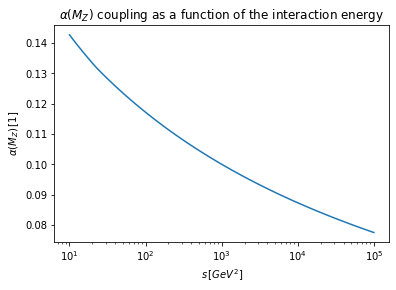

In [4]:
alpha_calc = utils.alphas.AlphaS(const.Z_MASS, const.QCD_COUPLING_Z_MASS)
energy_gev = np.logspace(1, 5, base=10, num=100)
res = []
for ene in energy_gev:
    res.append(alpha_calc(ene))

plt.plot(energy_gev, res)
plt.title("$\\alpha(M_Z)$ coupling as a function of the interaction energy")
plt.xscale("log")
plt.ylabel("$\\alpha(M_Z) \\, [1]$")
plt.xlabel("$s \\, [GeV^2]$")

plt.savefig(FIGURE_DIR / "ex_2a_alpha_coupling.png")
np.savetxt(DATA_DIR / "ex_2a_alpha_coupling.csv", np.c_[energy_gev, res])

## 2b)
This is an example of how the exercise could be done in this notebook. In
further calculations we use the own implementation from the module `integrate`.

In [5]:
quark_process = partial(integrate.quark_scattering_process, interval=interval)
theta_phi_flav_array = quark_process(samples)
theta, phi, flav = theta_phi_flav_array[0, 0], theta_phi_flav_array[0, 1], theta_phi_flav_array[0, 2]
four_momentum_e = {"E": 1, "px": 0, "py": 0, "pz": 1}
four_momentum_anti_e = {"E": 1, "px": 0, "py": 0, "pz": -1}
four_momentum_q = {
    "E": 1,
    "px": -np.cos(phi) * np.sin(theta),
    "py": -np.sin(phi) * np.sin(theta),
    "pz": -np.cos(theta)
}
four_momentum_anti_q = {
    "E": 1,
    "px": +np.cos(phi) * np.sin(theta),
    "py": +np.sin(phi) * np.sin(theta),
    "pz": +np.cos(theta)
}
q_momentum = utils.vector.Vec4(**four_momentum_q) * (np.sqrt(s) / 2)
anti_q_momentum = utils.vector.Vec4(**four_momentum_anti_q) * (np.sqrt(s) / 2)
e_momentum = utils.vector.Vec4(**four_momentum_e) * (np.sqrt(s) / 2)
anti_e_momentum = utils.vector.Vec4(**four_momentum_anti_e) * (np.sqrt(s) / 2)

Electron = partial(utils.particle.Particle, 11)
elec = Electron(e_momentum)
anti_elec = Electron(anti_e_momentum)
quark = utils.particle.Particle(flav, q_momentum, color=[1, 0])
anti_quark = utils.particle.Particle(flav, anti_q_momentum, color=[0, 1])

In [6]:
shower_runner = utils.shower.Shower(alpha_calc)
event = [elec, anti_elec, quark, anti_quark]
shower_runner.run(event, s)
event

[11 (45.6,0.0,0.0,45.6) [0, 0],
 11 (45.6,0.0,0.0,-45.6) [0, 0],
 4 (38.48979798015271,36.60410127918405,-3.583173879309311,-11.347474743168187) [2, 0],
 4.0 (42.78944114566022,-37.629317990043276,12.04006267779262,16.431907736989974) [0, 1],
 21 (9.92076087418707,1.0252167108592247,-8.456888798483309,-5.084432993821785) [1, 2]]

## 2c)
In addition to the mean of created particles we can see that the
distribution has a poisson-like structure.

In [7]:
samples = 1000
num_of_particles = []
for event in integrate.event_generator(samples, interval=interval, s=s):
    shower_runner.run(event, s)
    num_of_particles.append(len(event))

The average number of particles is 5.513.


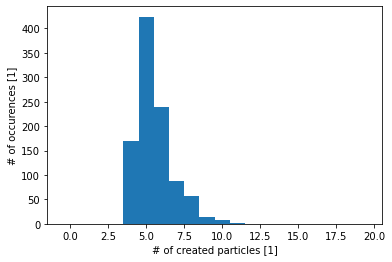

In [8]:
plt.hist(num_of_particles, bins=np.linspace(-.5, 19.5, num=21))
plt.ylabel("# of occurences [1]")
plt.xlabel("# of created particles [1]")
print(f"The average number of particles is {np.mean(num_of_particles)}.")

plt.savefig(FIGURE_DIR / "ex_2c_num_of_particles.png")
np.savetxt(DATA_DIR / "ex_2c_num_of_particles.csv", num_of_particles)

## 2e)
see 2d in the `utils.analysis` module from the provided library

In [9]:
analyzer = utils.analysis.Analysis()
for event in integrate.event_generator(samples, interval=interval, s=s):
    shower_runner.run(event, s)
    analyzer.analyze(event, weight=1)
analyzer.finalize(DATA_DIR / "analysis.yoda")

Plotting (might take a few moments) ...


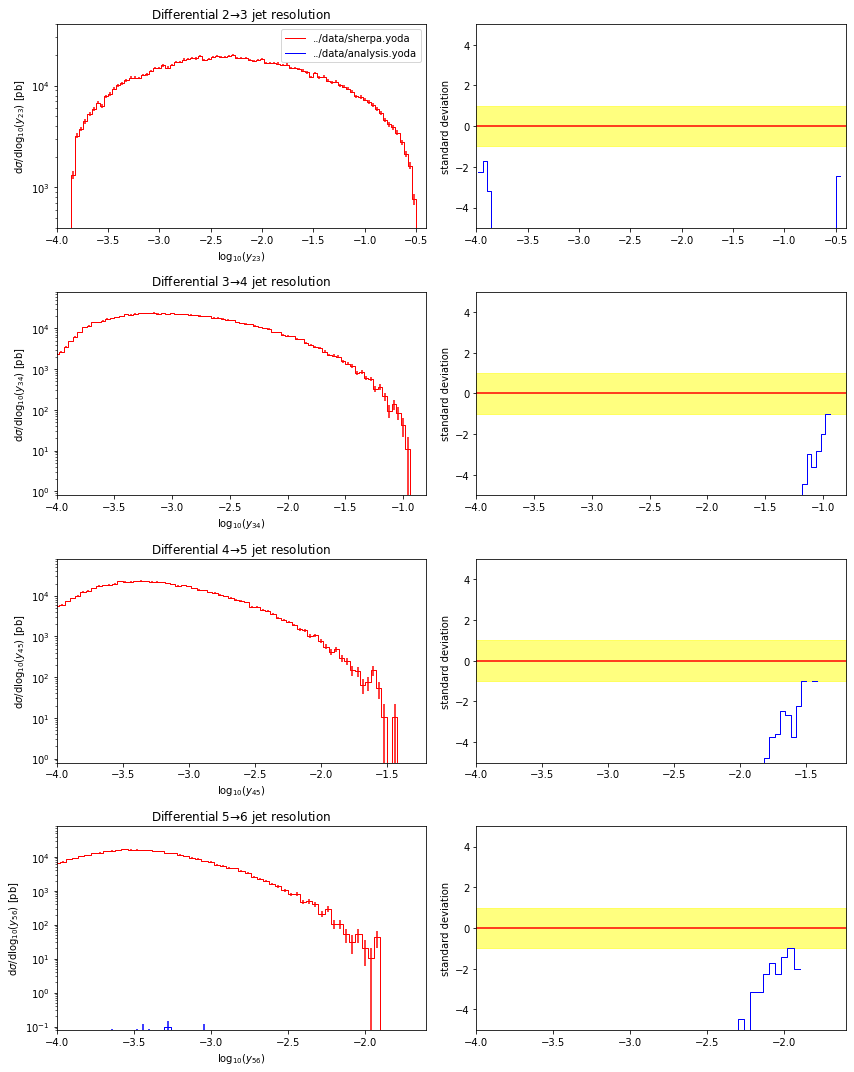

In [10]:
utils.yoda.plot_jet_histograms([
    DATA_DIR / "sherpa.yoda", DATA_DIR / "analysis.yoda"
])
plt.savefig(FIGURE_DIR / "ex_2e_jet_histograms.png")